In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import warnings
import h5py
import glob
from collections import Counter, defaultdict
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit, LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

In [2]:
def load_nef_values(folder_path="data/nef", save_path="data/nef_values.pkl"):
    search_pattern = os.path.join(folder_path, "*_values.pkl")
    files = glob.glob(search_pattern)
    nef_dfs = []
    for f in files:
        try:
            nef_dfs.append(pd.read_pickle(f).query("perturb == 0.0"))
        except Exception as e:
            print(f"Error loading {f}: {e}")
    nef_values = pd.concat(nef_dfs, ignore_index=True)
    nef_values['model_type'] = 'nef'
    nef_values.to_pickle(save_path)
    print(f"Successfully consolidated {len(files)} files into {save_path}")
    return nef_values
nef_values = load_nef_values()

Successfully consolidated 189 files into data/nef_values.pkl


In [3]:
def load_spikes_hdf5(filename):
    spikes = {}
    with h5py.File(filename, "r") as f:
            for trial in f.keys():
                spikes[int(trial)] = f[trial][:]
    return spikes

In [4]:
def plot_decoding_accuracy(score_df, target_var):
    """Plots the R2 accuracy over time for a single specific variable."""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
    sns.lineplot(data=score_df, x='time', y=target_var, color=palette[0])
    ax.set(title=target_var, xlabel='Time (s)', ylabel=r"$R^2$ Accuracy")
    plt.tight_layout()
    plt.show()

# Cross-validation decoding
Can split into training/testing data based on either trials or leave-one-out blocks

In [5]:
def CV_decoding(nef_values, monkey, session, train_bin_start, train_bin_end, target_vars, 
                leave_one_out='trials', loo_percent=0.1, alpha=1.0, bin_time=0.01, bin0_time=-1.0):
    
    # 1. Data Preparation
    flat_spikes, flat_y, trial_block_ids = [], [], []
    for block in range(1, 25):
        pathname = f"data/nef/monkey{monkey}_session{session}_block{block}_spikes.h5"
        try:
            b_spikes_dict = load_spikes_hdf5(pathname)
            b_meta = nef_values.query("monkey==@monkey & session==@session & block==@block")
            for i, t_key in enumerate(sorted(b_spikes_dict.keys())):
                flat_spikes.append(b_spikes_dict[t_key])
                flat_y.append(b_meta.iloc[i][target_vars].values)
                trial_block_ids.append(block)
        except Exception:
            continue
    
    n_trials = len(flat_spikes)
    n_bins = flat_spikes[0].shape[0]
    y_true = np.array(flat_y, dtype=float)
    groups = np.array(trial_block_ids)
    
    # 2. Define Splitter based on user choice
    if leave_one_out == 'block':
        from sklearn.model_selection import LeaveOneGroupOut
        cv = LeaveOneGroupOut()
        cv_args = {'groups': groups}
    else:
        from sklearn.model_selection import ShuffleSplit
        cv = ShuffleSplit(n_splits=5, test_size=loo_percent, random_state=42)
        cv_args = {}

    all_results = []

    # 3. Cross-Validation Loop
    for fold, (train_idx, test_idx) in enumerate(cv.split(np.arange(n_trials), **cv_args)):
        # Prepare Training Data (Every bin in window is a sample)
        X_train_list, y_train_list = [], []
        for i in train_idx:
            window_data = flat_spikes[i][train_bin_start:train_bin_end, :]
            X_train_list.append(window_data)
            y_val = y_true[i]
            y_train_list.append(np.tile(y_val, (train_bin_end - train_bin_start, 1)))
        
        X_train = np.vstack(X_train_list)
        y_train = np.vstack(y_train_list)
        
        # Fit model
        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        model.fit(X_train, y_train)
        
        # 4. Predict on the test set
        # We calculate R2 for each bin for this specific fold/block
        test_y_true = y_true[test_idx]
        fold_preds = np.zeros((len(test_idx), n_bins, len(target_vars)))
        
        for i_test, i_flat in enumerate(test_idx):
            preds = model.predict(flat_spikes[i_flat])
            if preds.ndim == 1: preds = preds[:, np.newaxis]
            fold_preds[i_test, :, :] = preds
            
        for b in range(n_bins):
            scores = r2_score(test_y_true, fold_preds[:, b, :], multioutput='raw_values')
            res = {'time': bin0_time + (b * bin_time), 'fold': fold}
            # If block-based, track the actual block ID for the error region
            if leave_one_out == 'block': res['block'] = groups[test_idx][0]
            
            for idx, var in enumerate(target_vars):
                res[var] = scores[idx]
            all_results.append(res)

    return pd.DataFrame(all_results)

In [7]:
score_trials = CV_decoding(nef_values, monkey='V', session=0, train_bin_start=190, train_bin_end=200, target_vars=['al','ar'], leave_one_out='trials', loo_percent=0.1)

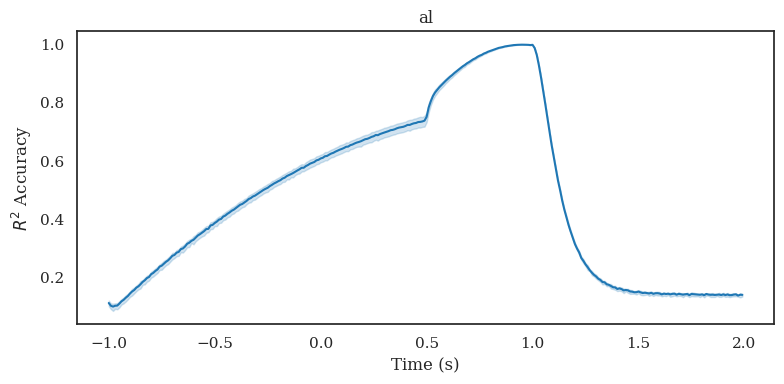

In [8]:
plot_decoding_accuracy(score_trials, target_var='al')

In [9]:
score_blocks = CV_decoding(nef_values, monkey='V', session=0, train_bin_start=190, train_bin_end=200, target_vars=['al','ar'], leave_one_out='block')

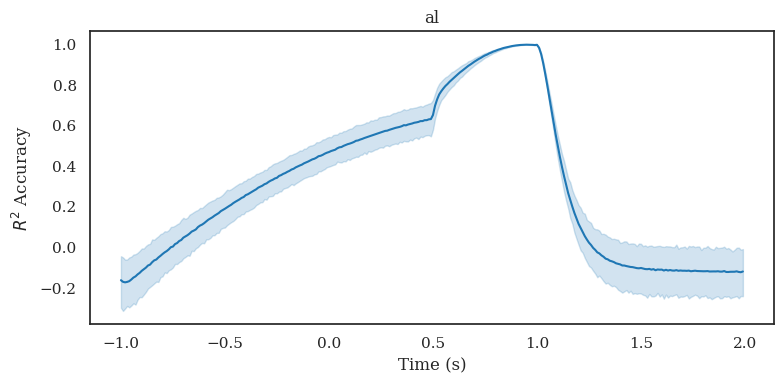

In [10]:
plot_decoding_accuracy(score_blocks, target_var='al')